In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt

# Reading the data frame and printing the first 5 rows
file_path = r'C:\Users\USUARIO\Desktop\field_production_monthly.csv'  
df = pd.read_csv(file_path)

df.head()

,prfInformationCarrier,prfYear,prfMonth,prfPrdOilNetMillSm3,prfPrdGasNetBillSm3,prfPrdNGLNetMillSm3,prfPrdCondensateNetMillSm3,prfPrdOeNetMillSm3,prfPrdProducedWaterInFieldMillSm3,prfNpdidInformationCarrier
0,16/1-12 Troldhaugen,2021,8,0.00653,0.00000,0.0,0.0,0.00653,0.00000,17196400
1,16/1-12 Troldhaugen,2021,9,0.02573,0.00173,0.0,0.0,0.02746,0.00719,17196400
2,16/1-12 Troldhaugen,2021,10,0.01172,0.00250,0.0,0.0,0.01422,0.00912,17196400
3,16/1-12 Troldhaugen,2021,11,0.01298,0.00199,0.0,0.0,0.01497,0.01186,17196400
4,16/1-12 Troldhaugen,2021,12,0.00461,0.00104,0.0,0.0,0.00565,0.00418,17196400


In [2]:
# keeping the first 4 columns 
df = df.iloc[:, :4]

# Renaming the columns
df.columns = ['Field (Discovery)', 'Year', 'Month', 'Net - oil [millSm3]']
df.head()

,Field (Discovery),Year,Month,Net - oil [millSm3]
0,16/1-12 Troldhaugen,2021,8,0.00653
1,16/1-12 Troldhaugen,2021,9,0.02573
2,16/1-12 Troldhaugen,2021,10,0.01172
3,16/1-12 Troldhaugen,2021,11,0.01298
4,16/1-12 Troldhaugen,2021,12,0.00461


In [3]:
# Keeping EKOFISK, ELDFISK, EMBLA fields
fields = ['EKOFISK', 'ELDFISK', 'EMBLA']

# Filtering Column "Field (Discovery)"
df_fields = df[df['Field (Discovery)'].isin(fields)]

# Printing the results
print(f"Rows: {len(df_fields)}")
print(df_fields['Field (Discovery)'].value_counts())

Rows: 1571
Field (Discovery)
EKOFISK    644
ELDFISK    546
EMBLA      381
Name: count, dtype: int64


In [4]:
# Keeping data from January 2015 onwards
df_year = df_fields[df_fields['Year'] >= 2015] 
# Verifying the years that were kept
print(df_year['Year'].value_counts().sort_index())

Year
2015    36
2016    36
2017    36
2018    36
2019    36
2020    36
2021    36
2022    36
2023    36
2024    36
2025     3
Name: count, dtype: int64


In [5]:
# Get the production data for the three fields and assign the name 'Greater Ekofisk Area' to the dataframe, calling it df_gea
df_gea = (
    df_year.groupby(['Year', 'Month'])['Net - oil [millSm3]']
    .sum()
    .reset_index()
    .rename(columns={'Net - oil [millSm3]': 'Greater Ekofisk Area'})
)
df_gea.head()

,Year,Month,Greater Ekofisk Area
0,2015,1,0.73901
1,2015,2,0.61044
2,2015,3,0.73576
3,2015,4,0.72402
4,2015,5,0.78961


In [6]:
# Creating a date column
df_gea['Datetime'] = pd.to_datetime(df_gea[['Year', 'Month']].assign(DAY=1))
df_gea = df_gea.sort_values('Datetime')  

# Formating date to export
df_gea['Date'] = df_gea['Datetime'].dt.strftime('%m/%d/%Y')

df_gea.head()

,Year,Month,Greater Ekofisk Area,Datetime,Date
0,2015,1,0.73901,2015-01-01,01/01/2015
1,2015,2,0.61044,2015-02-01,02/01/2015
2,2015,3,0.73576,2015-03-01,03/01/2015
3,2015,4,0.72402,2015-04-01,04/01/2015
4,2015,5,0.78961,2015-05-01,05/01/2015


In [7]:
# converting production data to thousand barrel per day
# considering 1 Sm3 = 6.29 barrels
days_in_month = df_gea['Datetime'].dt.days_in_month
df_gea['Mbbl/d'] = df_gea['Greater Ekofisk Area'] * 6.29 * 1000 / days_in_month

In [8]:
# Yearly average and monthly deviation
year_avg = df_gea.groupby('Year')[['Greater Ekofisk Area', 'Mbbl/d']].mean().reset_index()
year_avg = year_avg.rename(columns={'Greater Ekofisk Area': 'yearly_average', 'Mbbl/d': 'Yearly_Average_Mbbl/d'})

df_gea = pd.merge(df_gea, year_avg[['Year', 'yearly_average', 'Yearly_Average_Mbbl/d']], on='Year')
df_gea['monthly_deviation'] = df_gea['Greater Ekofisk Area'] - df_gea['yearly_average']

# 6-month moving average (centered)
df_gea['production_MA'] = df_gea['Greater Ekofisk Area'].rolling(window=6, min_periods=1).mean()

df_gea.head()

,Year,Month,Greater Ekofisk Area,Datetime,Date,Mbbl/d,yearly_average,Yearly_Average_Mbbl/d,monthly_deviation,production_MA
0,2015,1,0.73901,2015-01-01,01/01/2015,149.947513,0.749137,154.78402,-0.010127,0.739010
1,2015,2,0.61044,2015-02-01,02/01/2015,137.130986,0.749137,154.78402,-0.138697,0.674725
2,2015,3,0.73576,2015-03-01,03/01/2015,149.288077,0.749137,154.78402,-0.013377,0.695070
3,2015,4,0.72402,2015-04-01,04/01/2015,151.802860,0.749137,154.78402,-0.025117,0.702308
4,2015,5,0.78961,2015-05-01,05/01/2015,160.214416,0.749137,154.78402,0.040473,0.719768


In [217]:
# Create the final DataFrame with selected columns
output_cols = ['Greater Ekofisk Area', 'Date', 'Mbbl/d', 'yearly_average', 'monthly_deviation', 'production_MA']
df_final = df_gea[output_cols].copy()

# Save output
output_path = r'C:\Users\USUARIO\Desktop\greater_ekofisk_area_production.csv'
df_final.to_csv(output_path, index=False)

print(f"Filepath: {output_path}")

Filepath: C:\Users\USUARIO\Desktop\greater_ekofisk_area_production.csv


In [21]:
# Create the final DataFrame with required columns
df_final = df_gea[['Greater Ekofisk Area', 'Date', 'production_MA']].copy()

# Rename columns to match requested format
df_final = df_final.rename(columns={
    'Greater Ekofisk Area': 'production',
    'Date': 'date'
})

# Add constant 'project' column
df_final['project'] = 'Greater Ekofisk Area'

# Reorder columns to match requested sequence
df_final = df_final[['project', 'date', 'production', 'production_MA']]

# Save output
output_path = r'C:\Users\USUARIO\Desktop\greater_ekofisk_area_production.csv'
df_final.to_csv(output_path, index=False)

print(f"Arquivo salvo com sucesso em: {output_path}")
print("\nColunas no arquivo final:")
print(df_final.columns.tolist())

Arquivo salvo com sucesso em: C:\Users\USUARIO\Desktop\greater_ekofisk_area_production.csv

Colunas no arquivo final:
['project', 'date', 'production', 'production_MA']


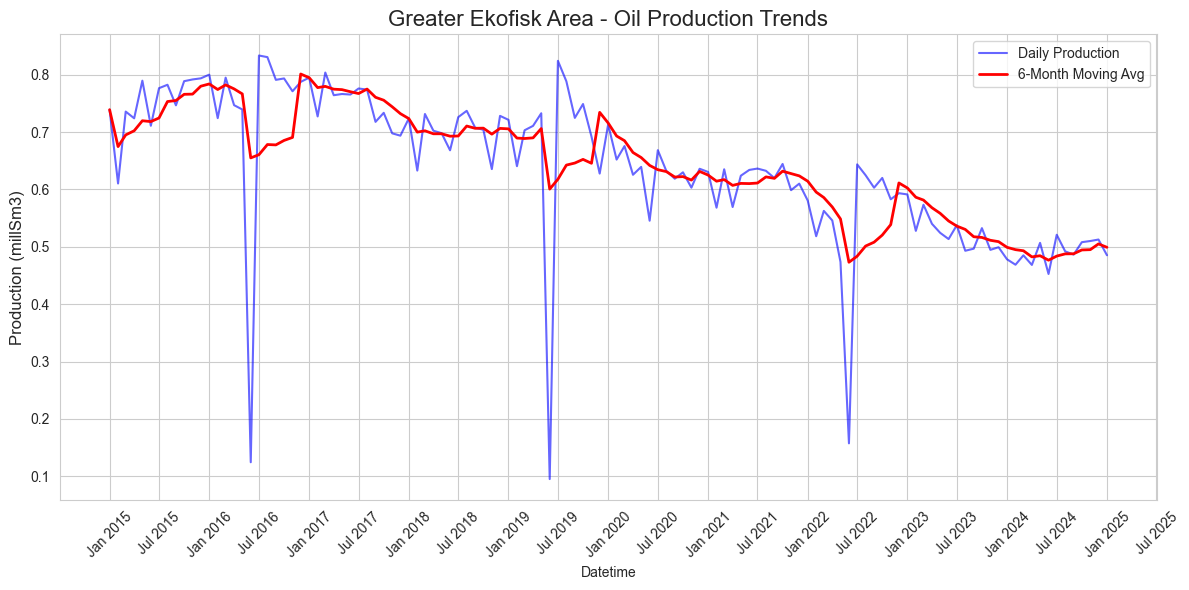

In [17]:
# ploting the results, including project, date, production and production_MA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Set style 
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(12, 6))

# Plot raw production data
sns.lineplot(
    data=df_gea,
    x='Datetime',
    y='Greater Ekofisk Area',
    label='Daily Production',
    color='blue',
    alpha=0.6
)

# Plot moving average (production_MA)
sns.lineplot(
    data=df_gea,
    x='Datetime',
    y='production_MA',
    label='6-Month Moving Avg',
    color='red',
    linewidth=2
)

# Customize plot
plt.title('Greater Ekofisk Area - Oil Production Trends', fontsize=16)
plt.xlabel('Datetime', fontsize=10)
plt.ylabel('Production (millSm3)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

df_gea.loc[:, "Datetime"] = pd.to_datetime(df_gea["Datetime"], format="%d/%m/%Y")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Show plot
plt.tight_layout()
plt.show()